In [85]:
# Import some basic libraries and functions for this tutorial.
import numpy as np
import os

from pydrake.common import temp_directory
from pydrake.geometry import SceneGraphConfig, StartMeshcat
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder, LeafSystem
from pydrake.visualization import AddDefaultVisualization, ModelVisualizer

import numpy
import pydrake.geometry
import pydrake.math
import pydrake.multibody.plant
import pydrake.multibody.tree
import pydrake.systems.framework
import pydrake.systems.primitives
from pydrake.math import RigidTransform as RigidTransform, RollPitchYaw as RollPitchYaw
from typing import Any, Callable, ClassVar, overload

from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ContactVisualizer,
    DiagramBuilder,
    ExternallyAppliedSpatialForce,
    LeafSystem,
    List,
    MeshcatVisualizer,
    VectorLogSink,
    ModelVisualizer,
    Parser,
    Simulator,
    SpatialForce,
    StartMeshcat,
    Value,
)

from manipulation import ConfigureParser, FindResource, running_as_notebook

In [2]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [16]:
# Define a simple cylinder model.

def create_cylinder_sdf(mass=1.0, inertia=[0.005833, 0.0, 0.0, 0.005833, 0.0, 0.005], radius=0.1, length=0.2, color=[1.0, 1.0, 1.0, 1.0]):
  cylinder_sdf = f"""<?xml version="1.0"?>
  <sdf version="1.7">
    <model name="cylinder">
      <pose>0 0 0 0 0 0</pose>
      <link name="cylinder_link">
        <inertial>
          <mass>{mass}</mass>
          <inertia>
            <ixx>{inertia[0]}</ixx>
            <ixy>{inertia[1]}</ixy>
            <ixz>{inertia[2]}</ixz>
            <iyy>{inertia[3]}</iyy>
            <iyz>{inertia[4]}</iyz>
            <izz>{inertia[5]}</izz>
          </inertia>
        </inertial>
        <collision name="collision">
          <geometry>
            <cylinder>
              <radius>{radius}</radius>
              <length>{length}</length>
            </cylinder>
          </geometry>
        </collision>
        <visual name="visual">
          <geometry>
            <cylinder>
              <radius>{radius}</radius>
              <length>{length}</length>
            </cylinder>
          </geometry>
          <material>
            <diffuse>{' '.join(map(str, color))}</diffuse>
          </material>
        </visual>
      </link>
    </model>
  </sdf>
  """
  return cylinder_sdf

cylinder_sdf = create_cylinder_sdf(radius=0.01)


In [152]:
# Create a Drake temporary directory to store files.
# Note: this tutorial will create a temporary file (table_top.sdf)
# in the `/tmp/robotlocomotion_drake_xxxxxx` directory.
temp_dir = temp_directory()

# Create a table top SDFormat model.
table_top_sdf_file = os.path.join(temp_dir, "table_top.sdf")
table_top_sdf = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="table_top">
    <link name="table_top_link">
      <visual name="visual">
        <pose>0 0 0.445 0 0 0</pose>
        <geometry>
          <box>
            <size>0.55 1.1 0.05</size>
          </box>
        </geometry>
        <material>
         <diffuse>0.9 0.8 0.7 1.0</diffuse>
        </material>
      </visual>
      <collision name="collision">
        <pose>0 0 0.445  0 0 0</pose>
        <geometry>
          <box>
            <size>0.55 1.1 0.05</size>
          </box>
        </geometry>
      </collision>
    </link>
    <frame name="table_top_center">
      <pose relative_to="table_top_link">0 0 0.47 0 0 0</pose>
    </frame>
  </model>
</sdf>

"""

with open(table_top_sdf_file, "w") as f:
    f.write(table_top_sdf)

# my experiment

In [20]:
def create_scene(sim_time_step):
    # Clean up the Meshcat instance.
    meshcat.Delete()
    meshcat.DeleteAddedControls()

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(
        builder, time_step=sim_time_step)
    parser = Parser(plant)

    # Loading models.
    # Load the table top and the cylinder we created.
    parser.AddModelsFromString(cylinder_sdf, "sdf")
    parser.AddModels(table_top_sdf_file)
    
    # Weld the table to the world so that it's fixed during the simulation.
    table_frame = plant.GetFrameByName("table_top_center")
    plant.WeldFrames(plant.world_frame(), table_frame)
    # Finalize the plant after loading the scene.
    plant.Finalize()
    # We use the default context to calculate the transformation of the table
    # in world frame but this is NOT the context the Diagram consumes.
    plant_context = plant.CreateDefaultContext()

    # Set the initial pose for the free bodies, i.e., the custom cylinder,
    cylinder = plant.GetBodyByName("cylinder_link")
    X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
    X_TableCylinder = RigidTransform(
        RollPitchYaw(np.asarray([0, 0, 0]) * np.pi / 180), p=[0,0,0.5])
    X_WorldCylinder = X_WorldTable.multiply(X_TableCylinder)
    plant.SetDefaultFreeBodyPose(cylinder, X_WorldCylinder)

    # Add visualization to see the geometries.
    AddDefaultVisualization(builder=builder, meshcat=meshcat)

    diagram = builder.Build()
    return diagram

In [ ]:
def initialize_simulation(diagram):
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.)
    return simulator


In [22]:
def run_all_hydroelastic_simulation(sim_time_step):
    diagram = create_scene(sim_time_step)
    
    # SceneGraphConfig lets us change default proximity properties for everything.
    scene_graph = diagram.GetSubsystemByName("scene_graph")
    config = SceneGraphConfig()
    config.default_proximity_properties.compliance_type = "compliant"
    config.default_proximity_properties.hunt_crossley_dissipation = 1.0
    scene_graph.set_config(config)
    
    simulator = initialize_simulation(diagram)
    meshcat.StartRecording()
    finish_time = 0.1 if test_mode else 5.0
    simulator.AdvanceTo(finish_time)
    meshcat.PublishRecording()

test_mode = False
# Run the simulation, similar to the one above. Notice that the contact physics
# are now different, and the that contact force arrows are red, instead of green.
run_all_hydroelastic_simulation(sim_time_step=0.002)

## make cylinder a system

In [31]:
meshcat.Delete()
meshcat.DeleteAddedControls()

builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.001)
parser = Parser(plant)
ConfigureParser(parser)
parser.AddModelsFromString(cylinder_sdf, "sdf")
parser.AddModels(table_top_sdf_file)
# Weld the table to the world so that it's fixed during the simulation.
table_frame = plant.GetFrameByName("table_top_center")
plant.WeldFrames(plant.world_frame(), table_frame)
# Finalize the plant after loading the scene.
plant.Finalize()
plant_context = plant.CreateDefaultContext()

# Set the initial pose for the free bodies, i.e., the custom cylinder,
cylinder = plant.GetBodyByName("cylinder_link")
X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
X_TableCylinder = RigidTransform(
    RollPitchYaw(np.asarray([0, 0, 0]) * np.pi / 180), p=[0,0,0.5])
X_WorldCylinder = X_WorldTable.multiply(X_TableCylinder)
plant.SetDefaultFreeBodyPose(cylinder, X_WorldCylinder)

visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
ContactVisualizer.AddToBuilder(builder, plant, meshcat)

diagram = builder.Build()

simulator = initialize_simulation(diagram)
meshcat.StartRecording()
finish_time = 5
simulator.AdvanceTo(finish_time)
meshcat.PublishRecording()


## apply force

In [37]:
meshcat.Delete()
meshcat.DeleteAddedControls()

class CylinderPusher(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)
        forces_cls = Value[List[ExternallyAppliedSpatialForce]]
        self.DeclareAbstractOutputPort(
            "applied_force", lambda: forces_cls(), self.CalcOutput
        )

    def CalcOutput(self, context, output):
        forces = []
        force = ExternallyAppliedSpatialForce()
        force.body_index = plant.GetBodyByName(f"cylinder_link").index()
        force.p_BoBq_B = -0.0125 * np.array([0,0,1])  # world 0, 0, 0
        force.F_Bq_W = SpatialForce(
            tau=-0.2 * np.array([0,0,0]),
            f=[1, 0, 9],
        )
        forces.append(force)
        output.set_value(forces)


builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.001)
parser = Parser(plant)
ConfigureParser(parser)
parser.AddModelsFromString(cylinder_sdf, "sdf")
parser.AddModels(table_top_sdf_file)
# Weld the table to the world so that it's fixed during the simulation.
table_frame = plant.GetFrameByName("table_top_center")
plant.WeldFrames(plant.world_frame(), table_frame)
# Finalize the plant after loading the scene.
plant.Finalize()
plant_context = plant.CreateDefaultContext()

# Set the initial pose for the free bodies, i.e., the custom cylinder,
cylinder = plant.GetBodyByName("cylinder_link")
X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
X_TableCylinder = RigidTransform(
    RollPitchYaw(np.asarray([0, 0, 0]) * np.pi / 180), p=[0,0,0.5])
X_WorldCylinder = X_WorldTable.multiply(X_TableCylinder)
plant.SetDefaultFreeBodyPose(cylinder, X_WorldCylinder)

visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
ContactVisualizer.AddToBuilder(builder, plant, meshcat)

pusher = builder.AddSystem(CylinderPusher())
builder.Connect(pusher.get_output_port(), plant.get_applied_spatial_force_input_port())

diagram = builder.Build()


simulator = initialize_simulation(diagram)
meshcat.StartRecording()
finish_time = 5
simulator.AdvanceTo(finish_time)
meshcat.PublishRecording()



## Logger of the cylinder

In [104]:
meshcat.Delete()
meshcat.DeleteAddedControls()

class CylinderPusher(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)
        forces_cls = Value[List[ExternallyAppliedSpatialForce]]
        self.DeclareAbstractOutputPort(
            "applied_force", lambda: forces_cls(), self.CalcOutput
        )
        # self.cylinder_pos_input = self.DeclareVectorInputPort(name="cylinder_pos", size=6)

    def CalcOutput(self, context, output):
        # cylinder_current_pos = self.cylinder_pos_input.Eval(context)
        # print("cylinder current pos: ", cylinder_current_pos)

        forces = []
        force = ExternallyAppliedSpatialForce()
        force.body_index = plant.GetBodyByName(f"cylinder_link").index()
        force.p_BoBq_B = -0.0125 * np.array([0,0,1])  # world 0, 0, 0
        force.F_Bq_W = SpatialForce(
            tau=-0.2 * np.array([0,0,0]),
            f=[0, 0, 9.8],
        )
        forces.append(force)
        output.set_value(forces)


builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.001)
parser = Parser(plant)
ConfigureParser(parser)
parser.AddModelsFromString(cylinder_sdf, "sdf")
parser.AddModels(table_top_sdf_file)
# Weld the table to the world so that it's fixed during the simulation.
table_frame = plant.GetFrameByName("table_top_center")
plant.WeldFrames(plant.world_frame(), table_frame)
# Finalize the plant after loading the scene.
plant.Finalize()
plant_context = plant.CreateDefaultContext()

# Set the initial pose for the free bodies, i.e., the custom cylinder,
cylinder = plant.GetBodyByName("cylinder_link")
X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
X_TableCylinder = RigidTransform(
    RollPitchYaw(np.asarray([0, 0, 0]) * np.pi / 180), p=[0,0,0.5])
X_WorldCylinder = X_WorldTable.multiply(X_TableCylinder)
plant.SetDefaultFreeBodyPose(cylinder, X_WorldCylinder)

visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
ContactVisualizer.AddToBuilder(builder, plant, meshcat)

pusher = builder.AddSystem(CylinderPusher())
logger = builder.AddSystem(VectorLogSink(13))

builder.Connect(pusher.get_output_port(), 
                plant.get_applied_spatial_force_input_port())

# builder.Connect(pusher.cylinder_pos_input, 
#                 plant.get_state_output_port(plant.GetModelInstanceByName("cylinder")))
builder.Connect(plant.get_state_output_port(plant.GetModelInstanceByName("cylinder")),
                logger.get_input_port(0))

diagram = builder.Build()


simulator = initialize_simulation(diagram)
context = simulator.get_mutable_context()

meshcat.StartRecording()
finish_time = 5
simulator.AdvanceTo(finish_time)
meshcat.PublishRecording()
q0 = plant.GetPositions(plant_context, plant.GetModelInstanceByName("cylinder"))
print("q0: ", q0)



q0:  [1. 0. 0. 0. 0. 0. 0.]


Text(0.5, 0, 'time (s)')

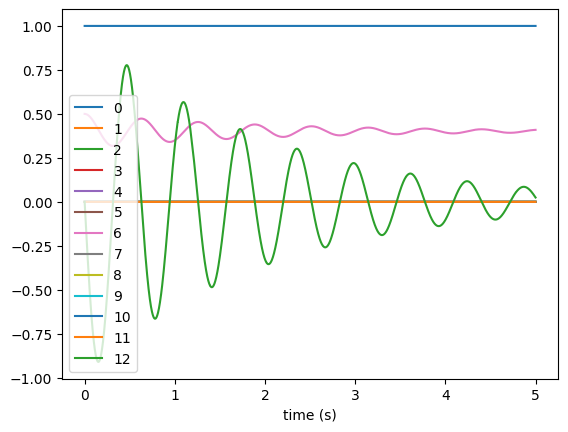

In [144]:
import matplotlib.pyplot as plt
time = logger.FindLog(context).sample_times()
traj = logger.FindLog(context).data()

plt.figure()
for i in range(traj.shape[0]):
    plt.plot(time, traj[i, :], label=str(i))
plt.legend()
plt.xlabel("time (s)")
# plt.ylabel("q (rads)")



Text(0.5, 0, 'time (s)')

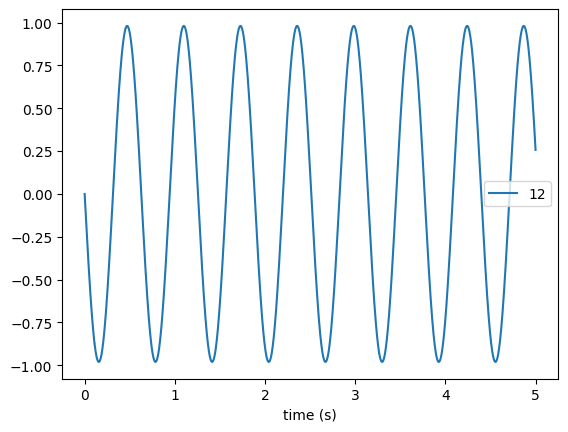

In [140]:
plt.figure()
plt.plot(time, traj[12, :], label=str(i))
plt.legend()
plt.xlabel("time (s)")

In [70]:
plant.num_multibody_states()

13

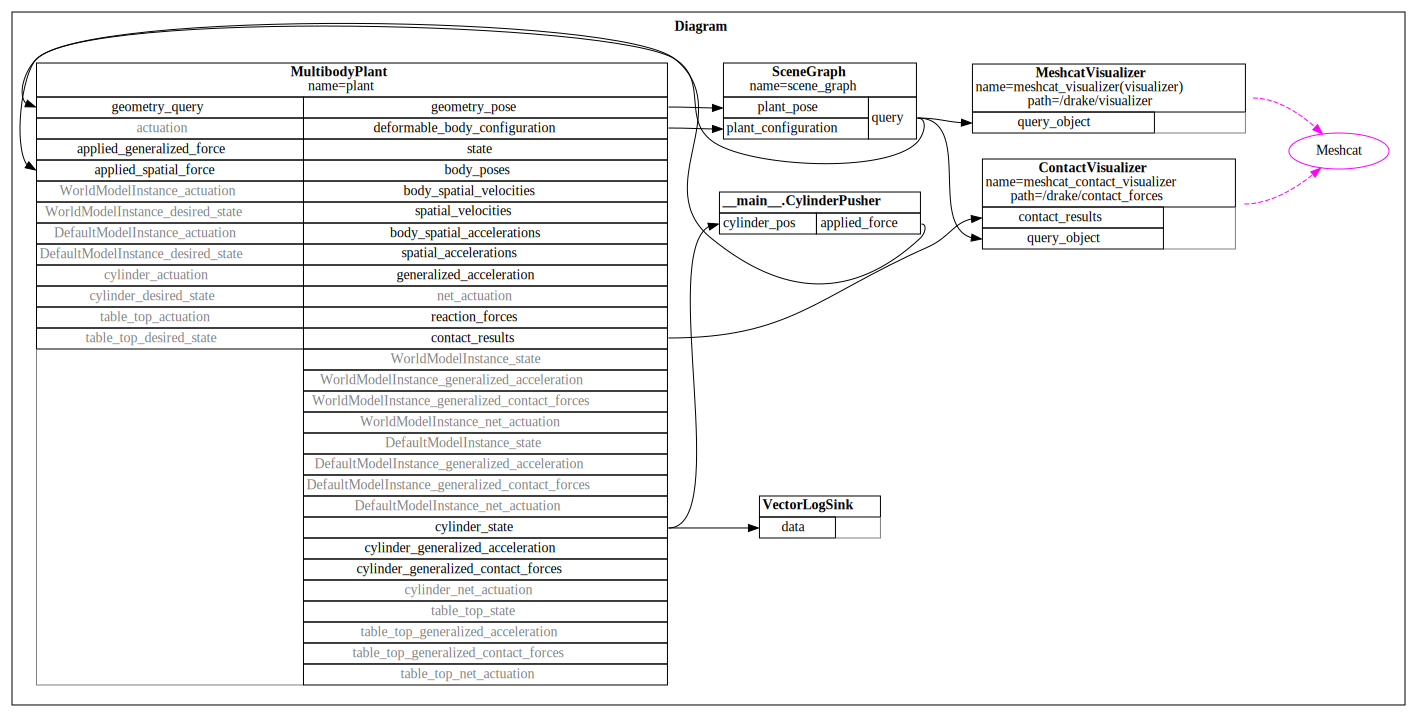

In [145]:
import pydot
from IPython.display import SVG, display


display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

## force related to the position of cylinder

In [163]:
meshcat.Delete()
meshcat.DeleteAddedControls()


builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.001)
parser = Parser(plant)
ConfigureParser(parser)
parser.AddModelsFromString(cylinder_sdf, "sdf")
parser.AddModels(table_top_sdf_file)
# Weld the table to the world so that it's fixed during the simulation.
table_frame = plant.GetFrameByName("table_top_center")
plant.WeldFrames(plant.world_frame(), table_frame)
# Finalize the plant after loading the scene.
plant.Finalize()
plant_context = plant.CreateDefaultContext()

# Set the initial pose for the free bodies, i.e., the custom cylinder,
cylinder = plant.GetBodyByName("cylinder_link")
X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
X_TableCylinder = RigidTransform(
    RollPitchYaw(np.asarray([0, 0, 0]) * np.pi / 180), p=[0,0,0.5])
X_WorldCylinder = X_WorldTable.multiply(X_TableCylinder)
plant.SetDefaultFreeBodyPose(cylinder, X_WorldCylinder)

visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
ContactVisualizer.AddToBuilder(builder, plant, meshcat)

class CylinderPusher(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)
        forces_cls = Value[List[ExternallyAppliedSpatialForce]]
        self.DeclareAbstractOutputPort(
            "applied_force", lambda: forces_cls(), self.CalcOutput
        )
        self.DeclareVectorInputPort(name="cylinder_pos", size=13)

    def CalcOutput(self, context, output):
        cylinder_current_state = self.get_input_port(0).Eval(context)
        cylinder_current_z = cylinder_current_state[6]
        delta_z = 0.5 - cylinder_current_z
        cylinder_current_vel_z = cylinder_current_state[12]
        k = 100
        b = 10

        forces = []
        force = ExternallyAppliedSpatialForce()
        force.body_index = plant.GetBodyByName(f"cylinder_link").index()
        force.p_BoBq_B = np.array([0,0,0])  # world 0, 0, 0
        # force.p_BoBq_B = cylinder.CalcCenterOfMassInBodyFrame(plant_context)    # pos in body frame 0 0 0
        # print(force.p_BoBq_B)
        force.F_Bq_W = SpatialForce(
            tau=np.array([0,0,0]),
            f=[0, 0, k*delta_z - b*cylinder_current_vel_z],
        )
        forces.append(force)
        output.set_value(forces)

pusher = builder.AddSystem(CylinderPusher())


logger = builder.AddSystem(VectorLogSink(13))

builder.Connect(pusher.get_output_port(), 
                plant.get_applied_spatial_force_input_port())

builder.Connect(plant.get_state_output_port(plant.GetModelInstanceByName("cylinder")),pusher.get_input_port(0))

builder.Connect(plant.get_state_output_port(plant.GetModelInstanceByName("cylinder")),
                logger.get_input_port(0))

diagram = builder.Build()


simulator = initialize_simulation(diagram)
context = simulator.get_mutable_context()

meshcat.StartRecording()
finish_time = 5
simulator.AdvanceTo(finish_time)
meshcat.PublishRecording()
q0 = plant.GetPositions(plant_context, plant.GetModelInstanceByName("cylinder"))
print("q0: ", q0)

q0:  [1. 0. 0. 0. 0. 0. 0.]


In [ ]:
class MySpring(LeafSystem):
    def __init__(self):
        super().__init__()  # Don't forget to initialize the base class.
        self._pos_a_port = self.DeclareVectorInputPort(name="pos_a", size=3)
        self._pos_b_port = self.DeclareVectorInputPort(name="pos_b", size=3)
        self.DeclareVectorOutputPort(name="sum", size=2, calc=self.CalcSum)
        self.DeclareVectorOutputPort(name="difference",
                                     size=2,
                                     calc=self.CalcDifference)

    def CalcSum(self, context, output):
        # Evaluate the input ports to obtain the 2x1 vectors.
        a = self._a_port.Eval(context)
        b = self._b_port.Eval(context)

        # Write the sum into the output vector.
        output.SetFromVector(a + b)

    def CalcDifference(self, context, output):
        # Evaluate the input ports to obtain the 2x1 vectors.
        a = self._a_port.Eval(context)
        b = self._b_port.Eval(context)

        # Write the difference into output vector.
        output.SetFromVector(a - b)

# Construct an instance of this system and a context.
system = MyAdder()
context = system.CreateDefaultContext()

# Fix the input ports to some constant values.
system.GetInputPort("a").FixValue(context, [3, 4])
system.GetInputPort("b").FixValue(context, [1, 2])

# Evaluate the output ports.
print(f"sum: {system.GetOutputPort('sum').Eval(context)}")
print(f"difference: {system.GetOutputPort('difference').Eval(context)}")